# 1. Describe the data
- It has 3236 rows.
- There are 9 varialbes:
    - school: A code representing 50 different schools (1-50).
    - class: A factor indicating the class level (1, 2, 3, 4).
    - gender: A factor with levels "boy" and "girl".
    - social: The social class of the father, coded as:
      - I = 1
      - II = 2
      - III nonmanual = 3
      - III manual = 4
      - IV = 5
      - V = 6
      - Long-term unemployed = 7
      - Not currently employed = 8
      - Father absent = 9
    - raven: The test score from the Raven's Progressive Matrices.
    - id: A unique student ID (coded 1-1402).
    - english: The score in English.
    - math: The score in Maths.
    - year: The year of school.
- Consider data from the Junior School Project collected from primary schools in inner London, detailed in Mortimore et al. (1988). We focus on two variables: the school (49 in total) and the mathematics test scores of their students.

# 2. Load packages and data

In [10]:
%%capture
pip install faraway

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import faraway.utils

In [12]:
import faraway.datasets.jsp
jsp = faraway.datasets.jsp.load()
# We focus on deviations from the average, we center the scores:
jsp['mathcent'] = jsp.math - np.mean(jsp.math)
jsp.head()

,school,class,gender,social,raven,id,english,math,year,mathcent
1,1,1,girl,9,23,1,72,23,0,-3.661928
2,1,1,girl,9,23,1,80,24,1,-2.661928
3,1,1,girl,9,23,1,39,23,2,-3.661928
4,1,1,boy,2,15,2,7,14,0,-12.661928
5,1,1,boy,2,15,2,17,11,1,-15.661928


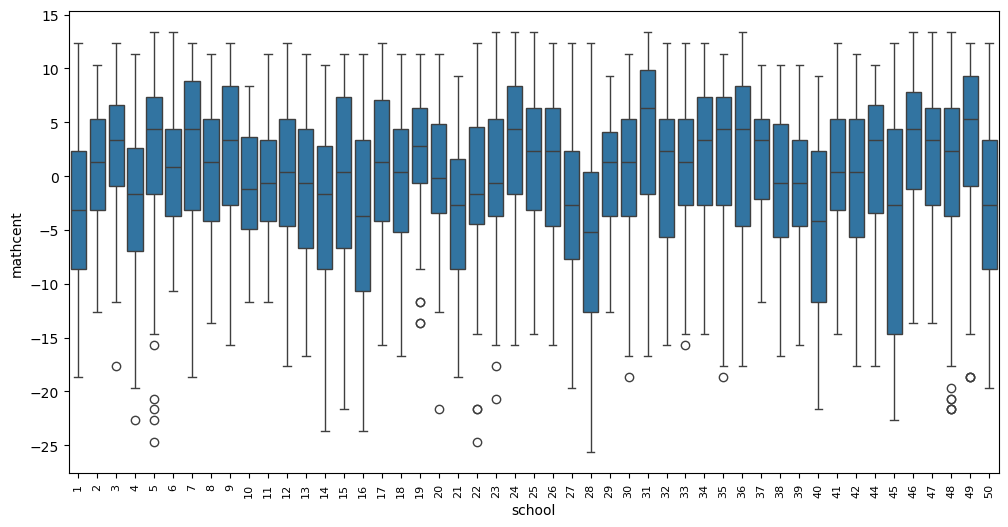

In [13]:
# Set the figure size to increase the width (e.g., 12 inches wide by 6 inches high)
plt.figure(figsize=(12, 6))
# Create a boxplot to visualize the distribution of centered mathematics test scores (mathcent) for each school
sns.boxplot(x="school", y="mathcent", data=jsp)
# Adjust the x-axis tick labels to have a font size of 8 and rotate them 90 degrees for better readability
plt.xticks(fontsize=8, rotation=90);

# 3. False Discovery Rate

In [14]:
# Choose the parameterization that omits the intercept term:
lmod = smf.ols("mathcent ~ C(school) - 1", jsp).fit()
pd.DataFrame(lmod.summary().tables[1]).iloc[[0,1,2,49],:]

,0,1,2,3,4,5,6
0,,coef,std err,t,P>|t|,[0.025,0.975]
1,C(school)[1],-3.3685,0.769,-4.383,0.000,-4.875,-1.861
2,C(school)[2],0.6714,1.229,0.546,0.585,-1.738,3.081
49,C(school)[50],-2.6520,0.734,-3.615,0.000,-4.090,-1.214


- Since the response is centered, t-tests for differences from zero are meaningful. Schools 1 and 50 are significantly below average, while school 2 is not significantly above average. We can test for differences between schools:

In [15]:
sm.stats.anova_lm(smf.ols("mathcent ~ C(school)", jsp).fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(school),48.0,15483.816175,322.579504,5.935264,1.458040e-33
Residual,3187.0,173212.333393,54.349650,NaN,NaN


- We find a strongly significant difference, unsurprising given the large sample size and expected differences between schools. The more interesting question is which schools show clear evidence of under- or over-performance?
- There are too many pairwise comparisons to focus on. Instead, let's identify schools with means significantly different from the average. Our parameterization simplifies these comparisons, but we expect about 5% of differences to be significant under the null hypothesis.
- Some adjustment is necessary. One approach is to control the familywise error rate (FWER), the overall probability of falsely declaring a difference. The Bonferroni correction is a simple method: multiply the unadjusted p-values by the number of comparisons, truncating any value above one. Let's see which schools have adjusted p-values less than 5%.
- The familywise error rate (FWER) is defined as the probability of making one or more Type I errors among a family of hypotheses tests. Mathematically: $ \text{FWER} = P(\text{At least one Type I error}) $. When conducting multiple comparisons, controlling the FWER ensures that the probability of at least one false positive remains below a specified significance level, typically denoted as $alpha$.

In [16]:
from statsmodels.stats.multitest import multipletests

# Perform multiple hypothesis testing correction using the Bonferroni method
# reject: array of booleans indicating whether to reject the null hypothesis for each test
# padj: array of adjusted p-values
# The last two values (_ and _) are placeholders for unused outputs
reject, padj, _, _ = multipletests(lmod.pvalues, method="bonferroni")

# Filter and display the model parameters where the null hypothesis is rejected
lmod.params[reject]

C(school)[1]    -3.368450
C(school)[16]   -3.737400
C(school)[21]   -3.618450
C(school)[28]   -5.828595
C(school)[31]    3.824053
C(school)[40]   -4.985458
C(school)[45]   -4.639201
C(school)[50]   -2.652027
dtype: float64

- Eight schools are identified, with all except school 31 significantly above average.
- The Bonferroni correction is conservative, and even more lenient methods impose stringent requirements as the number of comparisons increases.
- An alternative is to control the false discovery rate (FDR), the proportion of falsely identified significant effects, using the Benjamini and Hochberg (1995) method.
    - In this method, given sorted p-values $ p_{(i)} $ for $ i = 1, \ldots, m $, the procedure finds the largest index $ i $ where $ p_{(i)} \leq \alpha \frac{i}{m} $. All tests corresponding to p-values up to and including this index are considered significant.

In [17]:
# Get the indices of p-values sorted in ascending order
# Select indices where the sorted p-values are less than the corresponding threshold
# determined by the False Discovery Rate (FDR) method (Benjamini-Hochberg procedure)
selsch = np.argsort(lmod.pvalues)[np.sort(lmod.pvalues) < np.arange(1, 50) * 0.05 / 49]

# Retrieve the parameter names (or indices) corresponding to the selected indices
pd.DataFrame(lmod.params.index[selsch])

,0
0,C(school)[28]
1,C(school)[31]
2,C(school)[21]
3,C(school)[1]
4,C(school)[45]
5,C(school)[40]
6,C(school)[16]
7,C(school)[50]
8,C(school)[47]
9,C(school)[49]


- Eighteen schools are identified compared to eight by the previous procedure.
- FDR is less stringent than FWER in identifying significant effects.
- A more convenient method of computing the adjusted p-values is:

In [18]:
# Perform multiple hypothesis testing correction using the False Discovery Rate (FDR) method (Benjamini-Hochberg procedure)
# reject: array of booleans indicating whether to reject the null hypothesis for each test
# padj: array of adjusted p-values
# The last two values (_ and _) are placeholders for unused outputs
reject, padj, _, _ = multipletests(lmod.pvalues, method="fdr_bh")

# Filter and display the model parameters where the null hypothesis is rejected
lmod.params[reject]

C(school)[1]    -3.368450
C(school)[4]    -2.661928
C(school)[9]     2.245764
C(school)[14]   -3.289835
C(school)[16]   -3.737400
C(school)[21]   -3.618450
C(school)[24]    2.623786
C(school)[27]   -2.305764
C(school)[28]   -5.828595
C(school)[31]    3.824053
C(school)[34]    1.935898
C(school)[36]    2.360544
C(school)[40]   -4.985458
C(school)[45]   -4.639201
C(school)[46]    3.063562
C(school)[47]    2.396895
C(school)[49]    2.796405
C(school)[50]   -2.652027
dtype: float64

- FDR methods are common in imaging and bioinformatics, where large numbers of comparisons are necessary. They are useful for reliably identifying significant effects in such applications.